In [1]:
%matplotlib inline
import numpy as np
from skyfield.api import load
from scipy.optimize import newton
from matplotlib import pyplot as plt
import plotly
import plotly.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *
from footprint import *
from tno_models import trojan, plutino, twotino
init_notebook_mode(connected=True)
planets = load('de423.bsp')
plotly.tools.set_credentials_file(username='sevenlin123', api_key='vhjhhsCHepMx5oQGJPEp')

In [2]:
#p = plutino(size = 2000, mjd=58199, e_c = 0.3, e_sigma = 0.01, amp_c = 1, amp_max = 2, amp_min = 0)
p = plutino(size = 5000, mjd=57023)

(array([260., 246., 256., 265., 249., 235., 268., 253., 236., 237., 262.,
        269., 233., 224., 259., 236., 267., 224., 246., 266.]),
 array([39.25003678, 39.27003082, 39.29002486, 39.31001889, 39.33001293,
        39.35000697, 39.37000101, 39.38999504, 39.40998908, 39.42998312,
        39.44997716, 39.46997119, 39.48996523, 39.50995927, 39.52995331,
        39.54994735, 39.56994138, 39.58993542, 39.60992946, 39.6299235 ,
        39.64991753]),
 <a list of 20 Patch objects>)

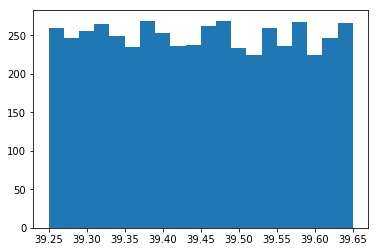

In [3]:
plt.hist(p.a, bins = 20)

(array([ 17.,  40.,  59., 145., 223., 416., 503., 604., 685., 637., 579.,
        421., 292., 186.,  99.,  49.,  28.,   3.,   4.,   1.]),
 array([0.0014468 , 0.02134996, 0.04125311, 0.06115626, 0.08105941,
        0.10096256, 0.12086572, 0.14076887, 0.16067202, 0.18057517,
        0.20047832, 0.22038148, 0.24028463, 0.26018778, 0.28009093,
        0.29999408, 0.31989724, 0.33980039, 0.35970354, 0.37960669,
        0.39950984]),
 <a list of 20 Patch objects>)

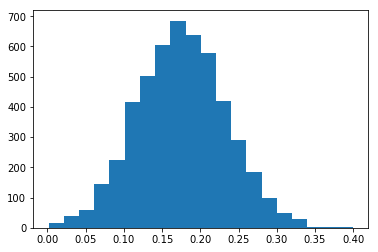

In [4]:
plt.hist(p.e, bins = 20)

(array([145., 405., 572., 676., 690., 607., 561., 404., 312., 236., 141.,
        107.,  59.,  24.,  14.,  19.,  10.,   3.,   3.,   3.]),
 array([ 0.26911728,  3.07093459,  5.87275189,  8.6745692 , 11.47638651,
        14.27820382, 17.08002112, 19.88183843, 22.68365574, 25.48547305,
        28.28729035, 31.08910766, 33.89092497, 36.69274228, 39.49455958,
        42.29637689, 45.0981942 , 47.90001151, 50.70182881, 53.50364612,
        56.30546343]),
 <a list of 20 Patch objects>)

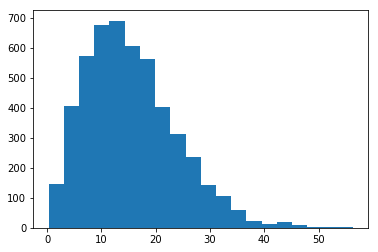

In [5]:
plt.hist(p.i*180/np.pi, bins = 20)

(array([3.000e+00, 1.000e+00, 1.000e+00, 4.000e+00, 2.000e+00, 5.000e+00,
        1.600e+01, 1.800e+01, 1.700e+01, 3.400e+01, 4.700e+01, 8.800e+01,
        1.190e+02, 1.640e+02, 2.500e+02, 3.440e+02, 5.060e+02, 7.660e+02,
        1.083e+03, 1.523e+03]),
 array([4.9058479 , 5.08555322, 5.26525853, 5.44496385, 5.62466917,
        5.80437448, 5.9840798 , 6.16378512, 6.34349043, 6.52319575,
        6.70290107, 6.88260638, 7.0623117 , 7.24201702, 7.42172233,
        7.60142765, 7.78113296, 7.96083828, 8.1405436 , 8.32024891,
        8.49995423]),
 <a list of 20 Patch objects>)

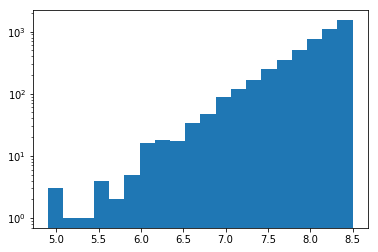

In [6]:
plt.yscale('log', nonposy='clip')
plt.hist(p.H, bins = 20)

(array([  2.,   2.,   6.,  20.,  18.,  41.,  68., 103., 178., 300., 426.,
        561., 633., 629., 620., 571., 497., 255.,  56.,   5.]),
 array([21.15736028, 21.41062955, 21.66389882, 21.91716809, 22.17043736,
        22.42370663, 22.6769759 , 22.93024517, 23.18351444, 23.43678371,
        23.69005298, 23.94332225, 24.19659152, 24.44986079, 24.70313006,
        24.95639933, 25.20966859, 25.46293786, 25.71620713, 25.9694764 ,
        26.22274567]),
 <a list of 20 Patch objects>)

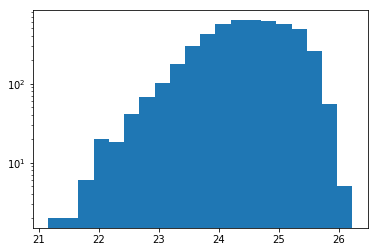

In [7]:
plt.yscale('log', nonposy='clip')
plt.hist(p.mag_r, bins = 20)

(array([265., 271., 249., 256., 256., 234., 255., 266., 241., 259., 236.,
        264., 230., 216., 251., 249., 259., 235., 255., 244.]),
 array([1.93055680e-04, 3.14141441e-01, 6.28089827e-01, 9.42038213e-01,
        1.25598660e+00, 1.56993498e+00, 1.88388337e+00, 2.19783176e+00,
        2.51178014e+00, 2.82572853e+00, 3.13967691e+00, 3.45362530e+00,
        3.76757369e+00, 4.08152207e+00, 4.39547046e+00, 4.70941884e+00,
        5.02336723e+00, 5.33731561e+00, 5.65126400e+00, 5.96521239e+00,
        6.27916077e+00]),
 <a list of 20 Patch objects>)

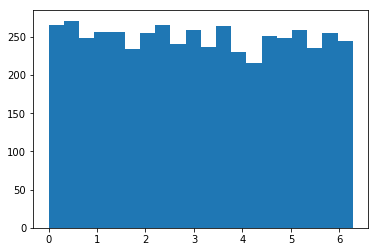

In [8]:
plt.hist(p.M, bins = 20)

(array([241., 241., 256., 253., 276., 264., 253., 264., 246., 247., 240.,
        241., 247., 233., 248., 230., 219., 303., 229., 260.]),
 array([9.45550128e-04, 3.14935613e-01, 6.28925677e-01, 9.42915740e-01,
        1.25690580e+00, 1.57089587e+00, 1.88488593e+00, 2.19887599e+00,
        2.51286606e+00, 2.82685612e+00, 3.14084618e+00, 3.45483625e+00,
        3.76882631e+00, 4.08281637e+00, 4.39680644e+00, 4.71079650e+00,
        5.02478656e+00, 5.33877663e+00, 5.65276669e+00, 5.96675675e+00,
        6.28074682e+00]),
 <a list of 20 Patch objects>)

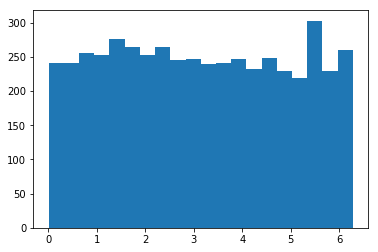

In [9]:
plt.hist(p.arg, bins = 20)

(array([252., 262., 259., 267., 255., 250., 288., 254., 237., 236., 268.,
        248., 255., 248., 248., 230., 262., 232., 222., 218.]),
 array([4.99470935e-04, 3.14590535e-01, 6.28681600e-01, 9.42772664e-01,
        1.25686373e+00, 1.57095479e+00, 1.88504586e+00, 2.19913692e+00,
        2.51322799e+00, 2.82731905e+00, 3.14141012e+00, 3.45550118e+00,
        3.76959224e+00, 4.08368331e+00, 4.39777437e+00, 4.71186544e+00,
        5.02595650e+00, 5.34004757e+00, 5.65413863e+00, 5.96822969e+00,
        6.28232076e+00]),
 <a list of 20 Patch objects>)

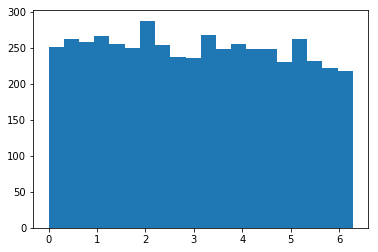

In [10]:
plt.hist(p.node, bins = 20)

(array([260., 233., 228., 259., 246., 249., 242., 262., 234., 257., 280.,
        249., 258., 228., 273., 233., 233., 246., 246., 275.]),
 array([2.19410963e-05, 3.14121641e-01, 6.28221341e-01, 9.42321041e-01,
        1.25642074e+00, 1.57052044e+00, 1.88462014e+00, 2.19871984e+00,
        2.51281954e+00, 2.82691924e+00, 3.14101894e+00, 3.45511864e+00,
        3.76921834e+00, 4.08331804e+00, 4.39741774e+00, 4.71151744e+00,
        5.02561714e+00, 5.33971684e+00, 5.65381654e+00, 5.96791624e+00,
        6.28201594e+00]),
 <a list of 20 Patch objects>)

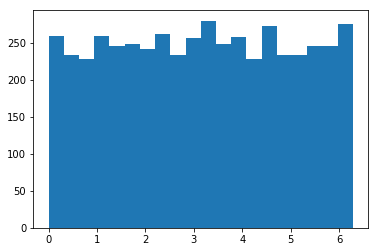

In [11]:
plt.hist((p.arg+p.node) % (2*np.pi), bins = 20)

(array([ 12.,  53., 100., 179., 242., 322., 355., 364., 409., 401., 410.,
        404., 419., 365., 327., 247., 180., 108.,  69.,  25.]),
 array([0.57290001, 0.82739319, 1.08188637, 1.33637956, 1.59087274,
        1.84536592, 2.09985911, 2.35435229, 2.60884547, 2.86333865,
        3.11783184, 3.37232502, 3.6268182 , 3.88131138, 4.13580457,
        4.39029775, 4.64479093, 4.89928412, 5.1537773 , 5.40827048,
        5.66276366]),
 <a list of 20 Patch objects>)

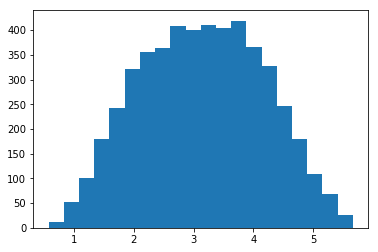

In [12]:
plt.hist(p.phi, bins = 20)

In [13]:
def kep_to_xyz(a, e, i, arg, node, M):
    # compute eccentric anomaly
    f = lambda E, M, e: E - e * np.sin(E) - M
    E0 = M
    E = newton(f, E0, args=(M, e))
    # compute true anomaly
    v = 2 * np.arctan2((1 + e)**0.5*np.sin(E/2.), (1 - e)**0.5*np.cos(E/2.))
    # compute the radius
    r = a * (1 - e*np.cos(E))
    # compute X,Y,Z
    X = r * (np.cos(node) * np.cos(arg + v) - np.sin(node) * np.sin(arg + v) * np.cos(i))
    Y = r * (np.sin(node) * np.cos(arg + v) + np.cos(node) * np.sin(arg + v) * np.cos(i))
    Z = r * (np.sin(i) * np.sin(arg + v))
    return X, Y, Z

In [14]:
xn, yn, zn = zip(*map(kep_to_xyz, 30+np.zeros(1000), np.zeros(1000), np.zeros(1000), np.zeros(1000), np.zeros(1000), np.arange(0, 6.28, 0.00628)))
x45, y45, z45 = zip(*map(kep_to_xyz, 45+np.zeros(1000), np.zeros(1000), np.zeros(1000), np.zeros(1000), np.zeros(1000), np.arange(0, 6.28, 0.00628)))

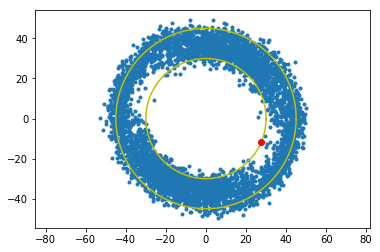

In [15]:
plt.axis('equal')
plt.scatter(p.X,p.Y, marker = '.')
plt.plot(xn, yn, 'y')
plt.plot(x45, y45, 'y')
plt.plot(p.x_n, p.y_n, 'ro')

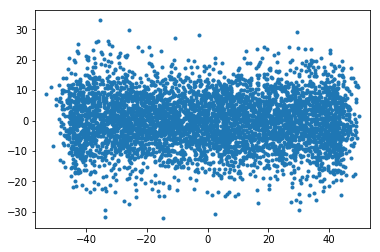

In [16]:
plt.axis('equal')
plt.scatter(p.X,p.Z, marker = '.')

In [17]:
def buildmap(obj_ra, obj_dec, ecliptic_plots=True):
    lon, lat = define_footprint(ecliptic_plots=ecliptic_plots) 
#    lon2, lat2 = define_footprint(polydef='poly_bliss_p9.txt', ecliptic_plots=ecliptic_plots) 
    m = Basemap(lon_0=0, projection='moll', celestial=True)
    x, y = m( lon, lat )
#    x2,y2 = m(lon2, lat2)
    xy = zip(x,y)
#    xy2 = zip(x2,y2)
    foot = patches.Polygon( xy, facecolor='cornflowerblue', edgecolor=None, alpha=0.4 )
#    foot2 = patches.Polygon( xy2, facecolor='lightpink', edgecolor=None, alpha=0.4 )
    plt.gca().add_patch(foot)
#    plt.gca().add_patch(foot2)
    fields = SNfields()
    for f in fields:
        if ecliptic_plots:
            ecl = ephem.Ecliptic(ephem.Equatorial(f.a_ra, f.a_dec))
            lon = ecl.lon if ecl.lon<ephem.degrees('180') else ecl.lon-2*np.pi    
            m.tissot(lon*180/np.pi, ecl.lat*180/np.pi, 1.05, 100, facecolor='g', alpha=0.5)
        else:
            ra = f.a_ra if f.a_ra<ephem.degrees('180') else f.a_ra-2*np.pi
            m.tissot(ra*180/np.pi, f.a_dec*180/np.pi, 1.05, 100, facecolor='r', alpha=0.5)
    obj_ra = obj_ra*180/np.pi
    obj_dec = obj_dec*180/np.pi
    for i in range(len(obj_ra)):
        m.scatter(obj_ra[i], obj_dec[i],3,marker='.',color='k', latlon=True)
    m.drawmapboundary()
    parallels = np.arange(-180.,181,20.)
    m.drawparallels(parallels,labels=[False,True,True,False], alpha=0.4)
    meridians = np.arange(-180.,181.,20.)
    m.drawmeridians(meridians, alpha=0.4)
    return m

In [18]:
#plt.figure(figsize=(20,10))
#m = buildmap(p.ra, p.dec, ecliptic_plots=False)

In [19]:
plutinos = Scatter3d(x=p.X, y=p.Y, z=p.Z, mode='markers', marker=dict(size=1, symbol='circle'), opacity=0.7, name='plutinos')
sun = Scatter3d(x=0, y=0, z=0, mode='markers', marker=dict(size=10, symbol='circle'), opacity=1, name='Sun')
neptune = Scatter3d(x=p.x_n, y=p.y_n, z=p.z_n, mode='markers', marker=dict(size=5, symbol='circle'), opacity=0.7, name ='Neptune')
fig = Figure(data=[plutinos, sun, neptune])
py.iplot(fig)

In [20]:
t = trojan(size = 5000, mjd=57023, i_sigma = 15)

tno_models.py:36: RuntimeWarning:

invalid value encountered in arcsin



(array([215., 184., 192., 200., 222., 213., 235., 201., 230., 186., 197.,
        212., 211., 205., 196., 213., 220., 203., 225., 214.]),
 array([29.90008547, 29.91257086, 29.92505626, 29.93754165, 29.95002704,
        29.96251244, 29.97499783, 29.98748323, 29.99996862, 30.01245401,
        30.02493941, 30.0374248 , 30.0499102 , 30.06239559, 30.07488098,
        30.08736638, 30.09985177, 30.11233716, 30.12482256, 30.13730795,
        30.14979335]),
 <a list of 20 Patch objects>)

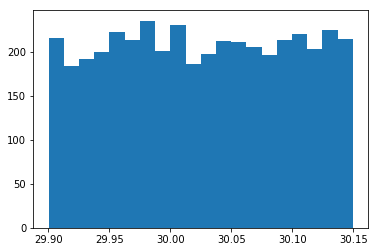

In [21]:
plt.hist(t.a, bins = 20)

(array([358., 412., 521., 529., 504., 464., 426., 319., 219., 156., 111.,
         70.,  44.,  28.,   6.,   4.,   1.,   1.,   0.,   1.]),
 array([1.52242305e-05, 1.05600235e-02, 2.11048228e-02, 3.16496222e-02,
        4.21944215e-02, 5.27392208e-02, 6.32840201e-02, 7.38288194e-02,
        8.43736187e-02, 9.49184180e-02, 1.05463217e-01, 1.16008017e-01,
        1.26552816e-01, 1.37097615e-01, 1.47642415e-01, 1.58187214e-01,
        1.68732013e-01, 1.79276812e-01, 1.89821612e-01, 2.00366411e-01,
        2.10911210e-01]),
 <a list of 20 Patch objects>)

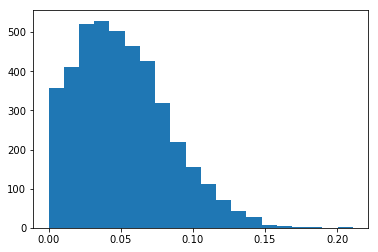

In [22]:
plt.hist(t.e, bins = 20)

(array([149., 389., 609., 596., 618., 512., 433., 291., 199., 150., 101.,
         48.,  27.,  14.,  16.,  10.,   5.,   4.,   2.,   1.]),
 array([ 0.22585587,  4.12719605,  8.02853623, 11.9298764 , 15.83121658,
        19.73255675, 23.63389693, 27.53523711, 31.43657728, 35.33791746,
        39.23925764, 43.14059781, 47.04193799, 50.94327817, 54.84461834,
        58.74595852, 62.6472987 , 66.54863887, 70.44997905, 74.35131922,
        78.2526594 ]),
 <a list of 20 Patch objects>)

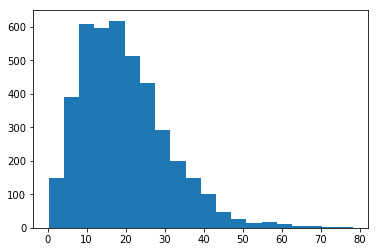

In [23]:
plt.hist(t.i*180/np.pi, bins = 20)

(array([ 53., 134., 214., 301., 366., 407., 394., 352., 304., 264., 227.,
        239., 216., 175., 170., 131.,  84.,  74.,  50.,  19.]),
 array([ 5.09596787,  6.07569243,  7.05541699,  8.03514155,  9.0148661 ,
         9.99459066, 10.97431522, 11.95403978, 12.93376434, 13.91348889,
        14.89321345, 15.87293801, 16.85266257, 17.83238713, 18.81211168,
        19.79183624, 20.7715608 , 21.75128536, 22.73100992, 23.71073448,
        24.69045903]),
 <a list of 20 Patch objects>)

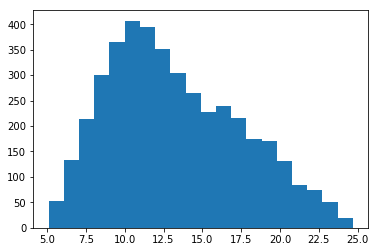

In [24]:
plt.hist(t.amp*180/np.pi, bins = 20)

(array([467., 922., 724.,  21.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,  34., 700., 911., 395.]),
 array([ 13.13996545,  27.51738621,  41.89480696,  56.27222772,
         70.64964847,  85.02706923,  99.40448998, 113.78191074,
        128.15933149, 142.53675225, 156.914173  , 171.29159376,
        185.66901451, 200.04643527, 214.42385602, 228.80127678,
        243.17869753, 257.55611829, 271.93353904, 286.3109598 ,
        300.68838055]),
 <a list of 20 Patch objects>)

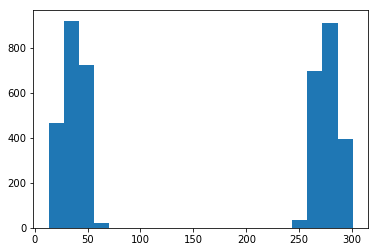

In [25]:
plt.hist((t.phi+t.lambda_N)%(2*np.pi)*180/np.pi, bins = 20)

(array([  1.,   0.,   1.,   2.,   3.,  12.,  10.,  19.,  42.,  51.,  85.,
        142., 220., 304., 569., 783., 979., 712., 216.,  23.]),
 array([20.90373097, 21.12247554, 21.3412201 , 21.55996466, 21.77870923,
        21.99745379, 22.21619835, 22.43494291, 22.65368748, 22.87243204,
        23.0911766 , 23.30992117, 23.52866573, 23.74741029, 23.96615485,
        24.18489942, 24.40364398, 24.62238854, 24.84113311, 25.05987767,
        25.27862223]),
 <a list of 20 Patch objects>)

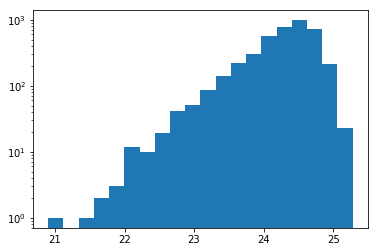

In [26]:
plt.yscale('log')
plt.hist(t.mag_r, bins = 20)

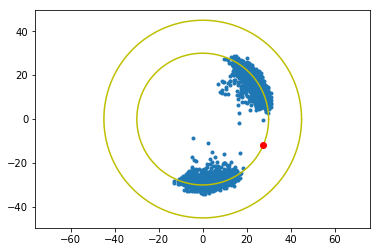

In [27]:
plt.axis('equal')
plt.scatter(t.X,t.Y, marker = '.')
plt.plot(xn, yn, 'y')
plt.plot(x45, y45, 'y')
plt.plot(t.x_n, t.y_n, 'ro')

In [28]:
trojan = Scatter3d(x=t.X, y=t.Y, z=t.Z, mode='markers', marker=dict(size=1, symbol='circle'), opacity=0.7, name='plutinos')
sun = Scatter3d(x=0, y=0, z=0, mode='markers', marker=dict(size=10, symbol='circle'), opacity=1, name='Sun')
neptune = Scatter3d(x=t.x_n, y=t.y_n, z=t.z_n, mode='markers', marker=dict(size=5, symbol='circle'), opacity=0.7, name ='Neptune')
fig = Figure(data=[trojan, sun, neptune])
py.iplot(fig)

In [29]:
#plt.figure(figsize=(20,10))
#m = buildmap(t.ra, t.dec, ecliptic_plots=False)

In [30]:
BC = np.loadtxt('radec_BC.list')
BD = np.loadtxt('radec_BD.list')
BH = np.loadtxt('radec_BH.list')
BL = np.loadtxt('radec_BL.list')
BS = np.loadtxt('radec_BS.list')
BT = np.loadtxt('radec_BT.list')
ma = np.loadtxt('radec_ma.list')

In [31]:
def buildmap_ecl(obj_ra, obj_dec):
    plt.figure(figsize=(20,10))
    m = Basemap(lon_0=0, projection='moll', celestial=True)
    plane_lon = np.arange(-np.pi, np.pi, .1*np.pi/180.)
    plane_lat = np.zeros(len(plane_lon))
    plane_p15 = np.zeros(len(plane_lon))+12*np.pi/180.
    plane_m15 = np.zeros(len(plane_lon))-12*np.pi/180.
    ecl_plane = np.zeros([len(plane_lat), 2])
    ecl_plane_p15 = np.zeros([len(plane_lat), 2])
    ecl_plane_m15 = np.zeros([len(plane_lat), 2])
    gal_plane = np.zeros([len(plane_lat), 2])
    for i in range(len(plane_lat)):
        ecl_plane[i] = ephem.Equatorial(ephem.Ecliptic(plane_lon[i], plane_lat[i])).get()
        ecl_plane_p15[i] = ephem.Equatorial(ephem.Ecliptic(plane_lon[i], plane_p15[i])).get()
        ecl_plane_m15[i] = ephem.Equatorial(ephem.Ecliptic(plane_lon[i], plane_m15[i])).get()
        gal_plane[i] = ephem.Equatorial(ephem.Galactic(plane_lon[i], plane_lat[i])).get()
        m.scatter(gal_plane[i][0]*180/np.pi, gal_plane[i][1]*180/np.pi,1,marker='o',color='steelblue', latlon=True)
        
    m.scatter(ecl_plane.T[0]*180/np.pi, ecl_plane.T[1]*180/np.pi,3,marker='o',color='darkorange', latlon=True)
    m.scatter(ecl_plane_p15.T[0]*180/np.pi, ecl_plane_p15.T[1]*180/np.pi,1,marker='.',color='orange', latlon=True)
    m.scatter(ecl_plane_m15.T[0]*180/np.pi, ecl_plane_m15.T[1]*180/np.pi,1,marker='.',color='orange', latlon=True)
    
    

    m.scatter(BC.T[0]*15, BC.T[1], 30,marker='s',color='crimson', alpha=0.6,  latlon=True, label='C Block')
    m.scatter(BD.T[0]*15, BD.T[1], 30,marker='s',color='orangered', alpha=0.6, latlon=True, label='D Block')
    m.scatter(BH.T[0]*15, BH.T[1], 30,marker='s',color='gold', alpha=0.6, latlon=True, label='H Block')
    m.scatter(BL.T[0]*15, BL.T[1], 30,marker='s',color='darkviolet', alpha=0.6, latlon=True, label='L Block')
    m.scatter(BS.T[0]*15, BS.T[1], 30,marker='s',color='hotpink', alpha=0.6, latlon=True, label='S Block')
    m.scatter(BT.T[0]*15, BT.T[1], 30,marker='s',color='violet', alpha=0.6, latlon=True, label='T Block')
    m.scatter(ma.T[0]*15, ma.T[1], 30,marker='s',color='limegreen', alpha=0.6, latlon=True, label='A16')

    obj_ra = obj_ra*180/np.pi
    obj_dec = obj_dec*180/np.pi
    
    m.scatter(obj_ra, obj_dec,3,marker='o',color='grey', alpha=0.4, latlon=True)

       
    m.drawmapboundary()
    parallels = np.arange(-180.,181,20.)
    m.drawparallels(parallels,labels=[False,True,True,False], alpha=0.8)
    meridians = np.arange(-180.,181.,20.)
    m.drawmeridians(meridians, alpha=0.4)
    plt.legend(fontsize = 16, loc = 4)
    return m

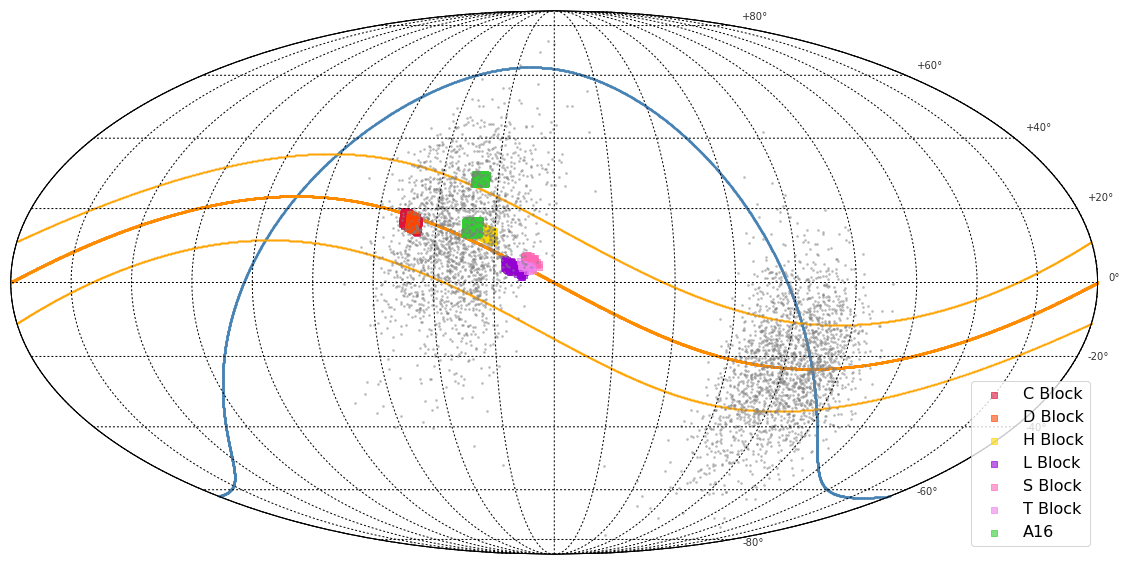

In [44]:
m = buildmap_ecl(t.ra, t.dec)
plt.savefig('fields.eps')

In [33]:
two = twotino(size = 5000, mjd=57023, amp_c = 3, amp_max = 5, amp_min = 0)

(array([186., 462., 653., 758., 728., 629., 523., 393., 269., 171., 114.,
         54.,  24.,  18.,  14.,   1.,   2.,   0.,   0.,   1.]),
 array([ 0.12249743,  1.61566847,  3.10883952,  4.60201056,  6.0951816 ,
         7.58835265,  9.08152369, 10.57469473, 12.06786578, 13.56103682,
        15.05420787, 16.54737891, 18.04054995, 19.533721  , 21.02689204,
        22.52006308, 24.01323413, 25.50640517, 26.99957621, 28.49274726,
        29.9859183 ]),
 <a list of 20 Patch objects>)

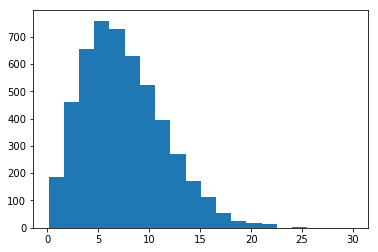

In [34]:
plt.hist((two.i)*180/np.pi, bins = 20)

(array([267., 323., 366., 321., 315., 342., 237., 148.,  62.,  55.,  51.,
         49., 143., 234., 387., 354., 347., 413., 332., 254.]),
 array([  7.4625021 ,  22.41886553,  37.37522895,  52.33159238,
         67.2879558 ,  82.24431923,  97.20068265, 112.15704608,
        127.1134095 , 142.06977293, 157.02613635, 171.98249977,
        186.9388632 , 201.89522662, 216.85159005, 231.80795347,
        246.7643169 , 261.72068032, 276.67704375, 291.63340717,
        306.5897706 ]),
 <a list of 20 Patch objects>)

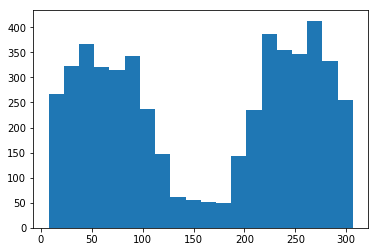

In [35]:
plt.hist((two.phi+two.lambda_N)%(2*np.pi)*180/np.pi, bins = 20)

(array([  1.,   0.,   1.,   2.,   3.,  12.,  10.,  19.,  42.,  51.,  85.,
        142., 220., 304., 569., 783., 979., 712., 216.,  23.]),
 array([20.90373097, 21.12247554, 21.3412201 , 21.55996466, 21.77870923,
        21.99745379, 22.21619835, 22.43494291, 22.65368748, 22.87243204,
        23.0911766 , 23.30992117, 23.52866573, 23.74741029, 23.96615485,
        24.18489942, 24.40364398, 24.62238854, 24.84113311, 25.05987767,
        25.27862223]),
 <a list of 20 Patch objects>)

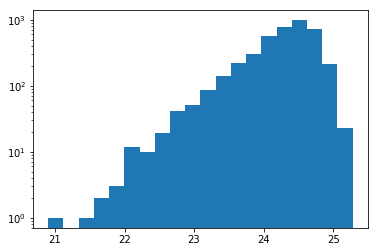

In [36]:
plt.yscale('log')
plt.hist(t.mag_r, bins = 20)

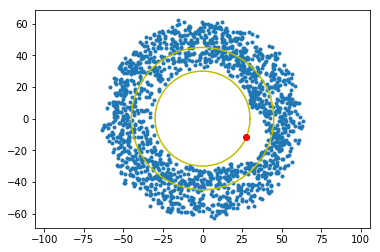

In [37]:
plt.axis('equal')
plt.scatter(two.X[two.phi0 == 0],two.Y[two.phi0 == 0], marker = '.')
plt.plot(xn, yn, 'y')
plt.plot(x45, y45, 'y')
plt.plot(two.x_n, two.y_n, 'ro')

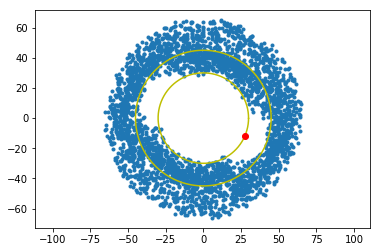

In [38]:
plt.axis('equal')
plt.scatter(two.X[two.phi0 != 0],two.Y[two.phi0 != 0], marker = '.')
plt.plot(xn, yn, 'y')
plt.plot(x45, y45, 'y')
plt.plot(two.x_n, two.y_n, 'ro')

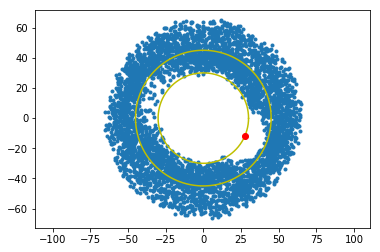

In [39]:
plt.axis('equal')
plt.scatter(two.X,two.Y, marker = '.')
plt.plot(xn, yn, 'y')
plt.plot(x45, y45, 'y')
plt.plot(two.x_n, two.y_n, 'ro')

In [40]:
twotinos = Scatter3d(x=two.X, y=two.Y, z=two.Z, mode='markers', marker=dict(size=1, symbol='circle'), opacity=0.7, name='twotinos')
sun = Scatter3d(x=0, y=0, z=0, mode='markers', marker=dict(size=10, symbol='circle'), opacity=1, name='Sun')
neptune = Scatter3d(x=two.x_n, y=two.y_n, z=two.z_n, mode='markers', marker=dict(size=5, symbol='circle'), opacity=0.7, name ='Neptune')
fig = Figure(data=[twotinos, sun, neptune])
py.iplot(fig)

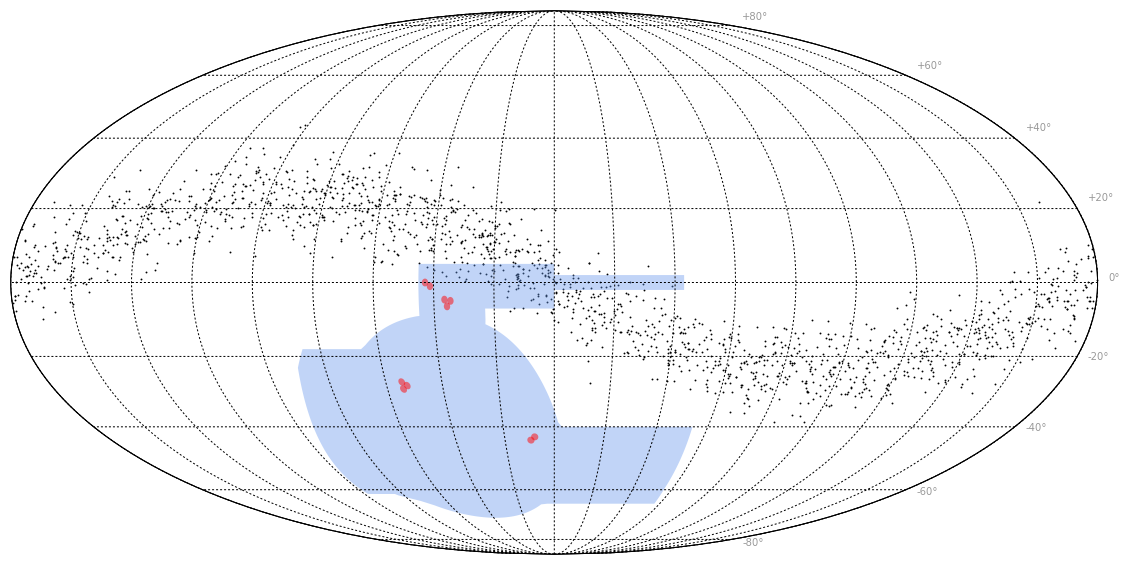

In [41]:
plt.figure(figsize=(20,10))
m = buildmap(two.ra[two.phi0 == 0], two.dec[two.phi0 == 0], ecliptic_plots=False)

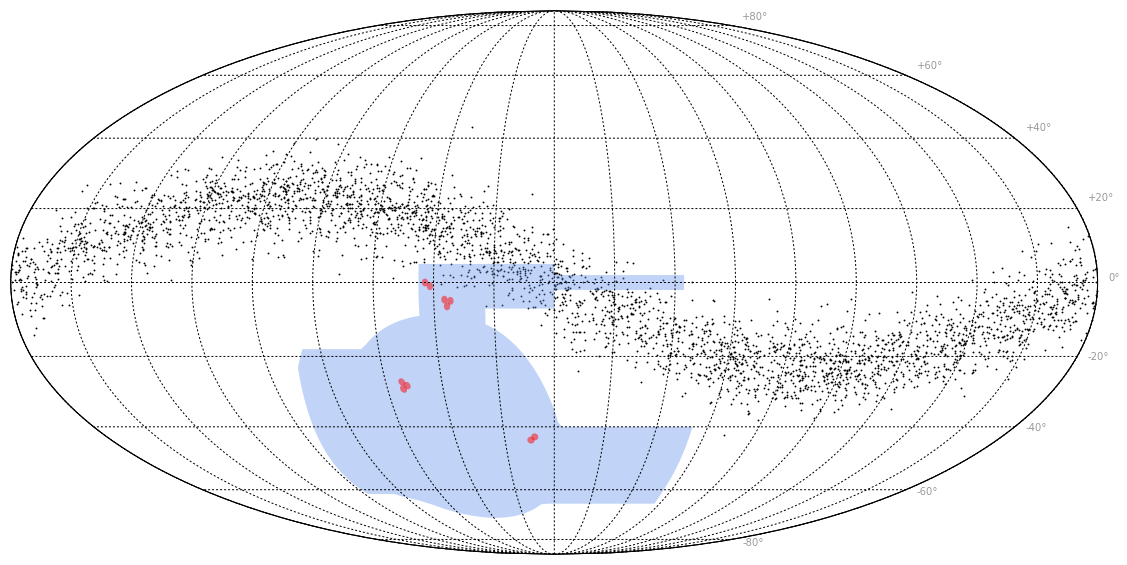

In [42]:
plt.figure(figsize=(20,10))
m = buildmap(two.ra[two.phi0 != 0], two.dec[two.phi0 != 0], ecliptic_plots=False)